In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import glob
import nibabel as nb
import itertools
import json
import sys
import statsmodels.api as sm
from statsmodels.formula.api import ols, wls
from statsmodels.formula.api import mixedlm
from patsy.contrasts import Treatment

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)

from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFdr
from sklearn.feature_selection import f_regression, mutual_info_regression

import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
np.random.seed(1024)

In [2]:
base_dir = '/home/abhijit/Jyotirmay/my_thesis'

In [3]:
smoking_feats = ['smoker_former', 'smoker_irregular', 'smoker_non_smoker', 'smoker_regular', 'smoking-packages']
bmi_feats = ['bmi-who_normal', 'bmi-who_obesity class I', 'bmi-who_obesity class II', 'bmi-who_obesity class III',
            'bmi_numeric', 'bmi-who_pre-obisety']
blood_pressure_feats = ['blood-pressure-diastolic', 'blood-pressure-systolic']
cholesterol_feats = ['cholesterol-hdl', 'cholesterol-ldl', 'cholesterol-total']
mri_feats = ['mri-liver-fat-artifacts', 'mri-liver-fat-lobus-dexter', 
             'mri-liver-fat-lobus-sinister', 'mri-liver-fat-portal-vein']
alcohol_feats = ['alcohol-g/day']
hbalc_feats = ['hba1c-mmol/mol', 'hba1c-percentage']
medication_feats = ['meds-antidiabetic', 'meds-antihypertensive', 'meds-incretin-mimetics', 'meds-insulin-therapy',
                    'meds-lipoprotein-lowering', 'meds-oral-antidiabetic']
triglyceride = ['triglyceride']
hypertension = ['hypertension']
basic_feats = ['age', 'height', 'sex', 'weight']

vols_feat = ['seg_liver', 'seg_spleen']
spleen_sample_cols = ['0_spleen','1_spleen','2_spleen','3_spleen','4_spleen','5_spleen','6_spleen','7_spleen','8_spleen','9_spleen']
liver_sample_cols = ['0_liver','1_liver','2_liver','3_liver','4_liver','5_liver','6_liver','7_liver','8_liver','9_liver']

feats_from_paper_for_group_test = [['age', 'sex', 'bmi_numeric'],
             ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'], ['hypertension'], ['triglyceride'],
             ['cholesterol_hdl', 'cholesterol_ldl'],
             ['mri_liver_fat_artifacts', 'mri_liver_fat_lobus_dexter', 
              'mri_liver_fat_lobus_sinister', 'mri_liver_fat_portal_vein'],
             ['meds_lipoprotein_lowering'],
             ['smoker_former', 'smoker_non_smoker', 'smoker_regular']]

feats_from_paper_for_group_test_no_categorisation = [['age', 'sex', 'bmi_numeric'],
             ['diabetes_status'], ['hypertension'], ['triglyceride'],
             ['cholesterol_hdl', 'cholesterol_ldl'],
             ['mri_liver_fat_artifacts', 'mri_liver_fat_lobus_dexter', 
              'mri_liver_fat_lobus_sinister', 'mri_liver_fat_portal_vein'],
             ['meds_lipoprotein_lowering'],
             ['smoker_former', 'smoker_non_smoker', 'smoker_regular']]

feats_from_paper_for_individual_test = [['age', 'sex', 'bmi_numeric'],
             ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'], ['hypertension'], ['triglyceride'],
             ['blood_pressure_diastolic', 'blood_pressure_systolic'],
             ['cholesterol_hdl', 'cholesterol_ldl', 'cholesterol_total'],
             ['mri_liver_fat_artifacts', 'mri_liver_fat_lobus_dexter', 
              'mri_liver_fat_lobus_sinister', 'mri_liver_fat_portal_vein'],
             ['meds_lipoprotein_lowering', 'meds_antihypertensive'],
             ['smoker_former', 'smoker_non_smoker', 'smoker_regular'], ['alcohol_g_day']]

feats_from_paper_for_individual_test_ukb = [['age', 'sex', 'bmi_numeric'],
             ['diabetes_status']]

paper_link = 'https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0177154&type=printable'

In [4]:
model_merged_feats_path = [
    {'full_bayesian': './projects/full_bayesian/reports/full_bayesian_KORA_v2/KORA/10_1571866968.4002764_concat_report_final.csv'},
    {'full_bayesian_0dot01': './projects/full_bayesian/reports/full_bayesian_KORA_v4/KORA/10_1572514598.527084_concat_report_final.csv'},
    {'MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_KORA_v2/KORA/10_1572006141.7793334_concat_report_final.csv'}, 
    {'probabilistic_quicknat': './projects/probabilistic_quicknat/reports/probabilistic_quicknat_KORA_v2/KORA/10_1571996796.7963011_concat_report_final.csv'}, 
    {'hierarchical_quicknat': './projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_concat_report_final.csv'}
]
all_dataset_merged_feats_path = [
    {'all_KORA_processed_False': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/all_processed_False_concat_report_final.csv'}, 
    {'all_KORA_processed_True': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/all_processed_True_concat_report_final.csv'}
]

test_dataset_merged_feats_path = [
    {'test_KORA_processed_False': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/test_processed_False_concat_report_final.csv'}, 
    {'test_KORA_processed_True': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/test_processed_True_concat_report_final.csv'}
]

all_paths = [
    {'full_bayesian': './projects/full_bayesian/reports/full_bayesian_KORA_v2/KORA/10_1571866968.4002764_concat_report_final.csv'},
    {'full_bayesian_0dot01': './projects/full_bayesian/reports/full_bayesian_KORA_v4/KORA/10_1572514598.527084_concat_report_final.csv'},
    {'MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_KORA_v2/KORA/10_1572006141.7793334_concat_report_final.csv'}, 
    {'probabilistic_quicknat': './projects/probabilistic_quicknat/reports/probabilistic_quicknat_KORA_v2/KORA/10_1571996796.7963011_concat_report_final.csv'}, 
    {'hierarchical_quicknat': './projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_concat_report_final.csv'},
    {'all_KORA_processed_False': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/all_processed_False_concat_report_final.csv'}, 
    {'all_KORA_processed_True': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/all_processed_True_concat_report_final.csv'},
    {'test_KORA_processed_False': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/test_processed_False_concat_report_final.csv'}, 
    {'test_KORA_processed_True': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/test_processed_True_concat_report_final.csv'}
]

final_model_report_path = [
    {'full_bayesian': './projects/full_bayesian/reports/full_bayesian_KORA_v2/KORA/10_1571866968.4002764_final_report.csv'},
    {'full_bayesian_0dot01': './projects/full_bayesian/reports/full_bayesian_KORA_v4/KORA/10_1572514598.527084_final_report.csv'},
    {'MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_KORA_v2/KORA/10_1572006141.7793334_final_report.csv'}, 
    {'probabilistic_quicknat': './projects/probabilistic_quicknat/reports/probabilistic_quicknat_KORA_v2/KORA/10_1571996796.7963011_final_report.csv'}, 
    {'hierarchical_quicknat': './projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_final_report.csv'}
]

ukb_paths = [
    {'MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_UKB_v2/UKB/10_1573078374.453554_concat_report_final.csv'}
]

fb = 'full_bayesian'
fb01 = 'full_bayesian_0dot01'
mc = 'MC_dropout_quicknat'
pq = 'probabilistic_quicknat'
hq = 'hierarchical_quicknat'
af = 'all_KORA_processed_False'
at = 'all_KORA_processed_True'
tf = 'test_KORA_processed_False'
tt = 'test_KORA_processed_True'

In [5]:
def plot_model_outputs(x, y, model_res, model_label='OLS', df=None):
    fig, ax = plt.subplots(figsize=(18,16))
    ax = sns.violinplot(x="diabetes_status", y=model_res.fittedvalues,
                   data=df, palette="Set2", split=True,
                   scale="count", inner="quartile")
    plt.show()

In [6]:
flatten = lambda l: [item for sublist in l for item in sublist]

def transform_to_categorical(df, categorical_features_list):
    for f in categorical_features_list:
        dfDummies = pd.get_dummies(df[f], prefix = f)
        df = pd.concat([df, dfDummies], axis=1)
    return df

def rename(df, cols_map=None):
    if cols_map is None:
        cols_map =  {'bmi-numeric':'bmi_numeric', 'blood-pressure-diastolic':'blood_pressure_diastolic', 'blood-pressure-systolic':'blood_pressure_systolic',
             'cholesterol-hdl':'cholesterol_hdl', 'cholesterol-ldl':'cholesterol_ldl', 'cholesterol-total':'cholesterol_total',
             'mri-liver-fat-artifacts':'mri_liver_fat_artifacts', 'mri-liver-fat-lobus-dexter':'mri_liver_fat_lobus_dexter', 
              'mri-liver-fat-lobus-sinister':'mri_liver_fat_lobus_sinister', 'mri-liver-fat-portal-vein':'mri_liver_fat_portal_vein',
             'meds-lipoprotein-lowering':'meds_lipoprotein_lowering', 'meds-antihypertensive':'meds_antihypertensive',
              'smoker_non-smoker':'smoker_non_smoker','alcohol-g/day':'alcohol_g_day'}
    df.rename(columns=cols_map, inplace=True)
    return df

def z_score_column_normalise(df, column_list):
    normalised_cols_map = {}
    for column in column_list:
        normalised_cols_map[column] = column+'_normalised'
        df[normalised_cols_map[column]] = (df[column] - df[column].mean())/df[column].std(ddof=0)
    return df, normalised_cols_map

def z_score_group_normalise(df, cols_to_normalise):
    normalised_cols_map = {}
    group_cols_value = df[cols_to_normalise].values
    mean, std = np.mean(group_cols_value), np.std(group_cols_value, ddof=0)
    for column in cols_to_normalise:
        normalised_cols_map[column] = column+'_normalised'
        df[normalised_cols_map[column]] = (df[column] - mean)/std
    return df, normalised_cols_map

def pre_process_for_mlm(df, to_be_transpose_cols, value_name):
    cols = list(df.columns)
    cols_without_tobe_transposed_cols = list(set(cols) - set(to_be_transpose_cols))
    df = df.melt(id_vars=cols_without_tobe_transposed_cols, 
            value_vars=to_be_transpose_cols, 
            value_name=value_name)

    return df

In [7]:
def split_diabetes_state(df):
    df_normal = df[df['diabetes_status']==0]
    df_pre_diabetic = df[df['diabetes_status']==1]
    df_diabetic = df[df['diabetes_status']==2]
    df_normal_affx = df_normal.rename(columns=lambda x: 'normal_'+x)
    df_pre_diabetic_affx = df_pre_diabetic.rename(columns=lambda x: 'pre_diabetic_'+x)
    df_diabetic_affx = df_diabetic.rename(columns=lambda x: 'diabetic_'+x)
    dfs = pd.concat([df_normal_affx, df_pre_diabetic_affx, df_diabetic_affx])
    return dfs

def plot_and_ttest(df, cols):
    dicts = {}
    for col_subset in itertools.combinations(cols, 2):
        print(f'{col_subset[0]} vs {col_subset[1]}')
        df[list(col_subset)].boxplot(rot=45)
        t,p = stats.ttest_ind(df[col_subset[0]].dropna().values, df[col_subset[1]].dropna().values)

        print('ttest_score:', t)
        print('p_value:', p)
        print('\n')
        dicts[f'{col_subset[0]} vs {col_subset[1]}'] = p
        plt.show()
    return dicts

In [8]:
def model_evaluation_matrics(file_paths_dict, cols_to_fetch):
    dicts = {}
    for model, path in file_paths_dict.items():
        df = pd.read_csv(path)
        dicts[model] = df[cols_to_fetch].iloc[1].values
    return dicts

In [9]:
def individual_feature_stats(feats, df, target_col, categorical_feats=['diabetes_status', 'sex']):
    p_values = {}
    for f in feats:
        try:
            features_string = f'1+C({f}, Treatment)' if f in categorical_feats else f'1+{f}'
            fii = ols(f'{target_col} ~ {features_string}', df).fit()
            feat_dict = fii.pvalues.to_dict()
            for k, v in feat_dict.items():
                p_values[k] = v
        except Exception as e:
            print(e)

    return p_values

In [10]:

significance_check = lambda x: False if x>0.05 else True
def group_feature_stats(features_string, df, target_col):
    p_values, fii = None, None
    try:
        fii = ols(f'{target_col} ~ {features_string}', df).fit()
        p_values = fii.pvalues.to_dict()
    except Exception as e:
        print(e)

    return p_values, fii


In [11]:

def make_feature_string(feats, categorical_cols=[]):
    feat_str = '1+'
    for c_col in categorical_cols:
        if type(c_col) is tuple:
            if c_col[0] not in feats:
#                 print(f'{c_col} is not present in given feature list, SKIPPING IT!')
                continue
            feat_str += f'C({c_col[0]}, Treatment(reference={c_col[1]}))+'
            c_col = c_col[0]
        else:
            if c_col not in feats:
#                 print(f'{c_col} is not present in given feature list, SKIPPING IT!')
                continue
            feat_str += f'C({c_col}, Treatment)+'
        feats.remove(c_col)
    
    other_feats_str = '+'.join(feats)
    if other_feats_str is '':
        final_feat_str = feat_str[:-1]
    else:
        final_feat_str = feat_str + other_feats_str

    return final_feat_str
    

def normal_group_fit(df, target_col, features_string):
    model = ols(f'{target_col} ~ {features_string}', df).fit()
    plot_model_outputs(df['bmi_numeric'].values, df[target_col].values, model, 'OLS')
    return model

def weighted_group_feats(df, target_col, features_string, alpha_col):
    alpha = df[alpha_col].values
    model = wls(f'{target_col} ~ {features_string}', df, weights=(1/(1-alpha))).fit()
    return model

def normal_mixed_effect_model(df, target_col, features_string, group_col, L1_wt=None):
    if L1_wt is None:
        model = mixedlm(f'{target_col} ~ {features_string}', df, groups=df[group_col]).fit()
    else:
        model = mixedlm(f'{target_col} ~ {features_string}', df, groups=df[group_col]).fit_regularized(L1_wt=L1_wt)
    return model

def anova_test(ols_model):
    anova_stats = sm.stats.anova_lm(ols_model)
    return anova_stats

In [12]:
def gathering_p_values():
    pass

In [13]:
def df_from_nested_dicts(dicts):
    df = pd.concat({k+'_'+kk: pd.concat({kk:pd.DataFrame(vv, index=[0]).T}, axis=1) for k, v in dicts.items() for kk, vv in v.items()}, axis=1)
    return df

def df_from_nested_dicts_group(dicts):
    df = pd.concat({k+'_'+kk: pd.concat({kk:pd.DataFrame(vv, index=[0]).T}, axis=1) for k, v in dicts.items() for kk, vv in v.items()}, axis=1)
    return df

def highlight_significance(df, threshold=0.05):
    return df.style.applymap(lambda x: 'background-color : yellow' if x==True or x<threshold else '')

In [14]:
model_merged_feats_path_combined = {key:val for d in all_paths for key,val in d.items()}
only_models_final_report_path = {key:val for d in final_model_report_path for key,val in d.items()}
ukb_paths_conbined = {key:val for d in ukb_paths for key,val in d.items()}

# Activate only on UKB data analysis

In [15]:
# only_models_final_report_path = ukb_paths_conbined
# model_merged_feats_path_combined = ukb_paths_conbined
# feats_from_paper_for_individual_test = feats_from_paper_for_individual_test_ukb
# feats_from_paper_for_group_test = feats_from_paper_for_individual_test_ukb
# feats_from_paper_for_group_test_no_categorisation = feats_from_paper_for_individual_test_ukb

# Model Evaluations

In [16]:
cols_to_fetch = ['sncc', 'ged', 'iou_spleen', 'iou_liver', 'dice_spleen',
       'dice_liver', 'surface_distance_avg_spleen', 'surface_distance_avg_liver']
dicts = model_evaluation_matrics(only_models_final_report_path, cols_to_fetch)
df_model_eval = pd.DataFrame.from_dict(dicts)
df_model_eval = df_model_eval.T
df_model_eval.columns = cols_to_fetch
df_model_eval

,sncc,ged,iou_spleen,iou_liver,dice_spleen,dice_liver,surface_distance_avg_spleen,surface_distance_avg_liver
full_bayesian,0.604205,0.223997,0.524697,0.668660,0.828703,0.894704,0.809946,0.736798
full_bayesian_0dot01,0.439956,0.195701,0.778342,0.843610,0.876280,0.921408,0.878530,0.817305
MC_dropout_quicknat,0.399954,0.166135,0.821329,0.878295,0.897294,0.937717,0.915982,0.870747
probabilistic_quicknat,0.163864,0.228308,0.988114,0.992439,0.873666,0.925428,0.875153,0.827462
hierarchical_quicknat,0.187984,0.209171,0.983818,0.988998,0.883146,0.932802,0.897351,0.854833


# Feature Selection

In [17]:
def choose_best_features(df, feats, target_col, percentile=50):
    X, y = df[feats], df[target_col]
    columns = X.columns.values
#     feat_selection_model = SelectPercentile(f_regression, percentile=percentile).fit(X, y)
    feat_selection_model = SelectFdr(f_regression, alpha=0.05).fit(X, y)
#     print(feat_selection_model.pvalues_, feat_selection_model.scores_)
    col_mask = feat_selection_model.get_support()
    return columns[col_mask]
    

In [18]:
# df = pd.read_csv('./projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_KORA_v2/KORA/10_1572006141.7793334_concat_report_final.csv', index_col=0)
# df = rename(df)
# df = transform_to_categorical(df, ['diabetes_status'])
# df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
# df = df.fillna(0)
# X, y = df[flatten(feats_from_paper_for_individual_test)], df.seg_liver_normalised
# columns = X.columns.values

# x_kbest_fregress = SelectKBest(f_regression, k=12).fit(X, y)
# x_kbest_mutual_info_regress = SelectKBest(mutual_info_regression, k=12).fit(X, y)
# x_percentile_fregress = SelectPercentile(f_regression, percentile=50).fit(X, y)
# x_percentile__mutual_info_regress  = SelectPercentile(mutual_info_regression, percentile=50).fit(X, y)

# x_kbest_fregress_mask = x_kbest_fregress.get_support()
# x_kbest_mutual_info_regress_mask = x_kbest_mutual_info_regress.get_support()
# x_percentile_fregress_mask = x_percentile_fregress.get_support()
# x_percentile__mutual_info_regress_mask = x_percentile__mutual_info_regress.get_support()


# print(columns[x_kbest_fregress_mask])
# print(columns[x_kbest_mutual_info_regress_mask])
# print(columns[x_percentile_fregress_mask])
# print(columns[x_percentile__mutual_info_regress_mask])

# choose_best_features(df, flatten(feats_from_paper_for_group_test_no_categorisation), 'seg_liver_normalised')

# Individual feats stats test

In [19]:
feats = flatten(feats_from_paper_for_group_test_no_categorisation)
dicts = {}
best_feats_spleen, best_feats_liver = None, None
for key, value in model_merged_feats_path_combined.items():
    df = pd.read_csv(value)
    df = rename(df)
#     df = transform_to_categorical(df, ['diabetes_status'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
    df = df.fillna(0)
    
    dicts[key] = {}
    target_col = 'seg_spleen_normalised'
    best_feats_spleen = choose_best_features(df, feats, target_col, 90)
    p_value_dict = individual_feature_stats(best_feats_spleen, df, target_col)
    dicts[key][target_col] = p_value_dict
    
    target_col = 'seg_liver_normalised'
    best_feats_liver = choose_best_features(df, feats, target_col, 90)
    p_value_dict = individual_feature_stats(best_feats_liver, df, target_col)
    dicts[key][target_col] = p_value_dict

p_value_df = df_from_nested_dicts(dicts).T
p_value_df_styler = highlight_significance(p_value_df, threshold=0.0001)
p_value_df_styler


,,,"C(diabetes_status, Treatment)[T.1]","C(diabetes_status, Treatment)[T.2]","C(sex, Treatment)[T.1]",Intercept,age,bmi_numeric,cholesterol_hdl,cholesterol_ldl,hypertension,mri_liver_fat_artifacts,mri_liver_fat_lobus_dexter,mri_liver_fat_lobus_sinister,mri_liver_fat_portal_vein,smoker_former,smoker_non_smoker,smoker_regular,triglyceride
full_bayesian_seg_spleen_normalised,seg_spleen_normalised,0,nan,nan,2.72908e-05,0.0265301,0.0130894,0.000114848,4.27486e-05,nan,nan,nan,0.00444926,0.00519153,0.00129411,nan,nan,nan,nan
full_bayesian_seg_liver_normalised,seg_liver_normalised,0,0.00711406,0.0230929,0.000535959,0.0954473,0.00446718,1.20002e-12,3.6157e-09,nan,0.000421669,nan,0.00721136,0.0197469,nan,nan,nan,nan,1.24211e-05
full_bayesian_0dot01_seg_spleen_normalised,seg_spleen_normalised,0,nan,nan,7.6422e-05,0.0324692,0.0095782,1.4362e-07,5.13724e-06,nan,nan,nan,0.00527291,0.00570451,0.00191228,nan,nan,nan,nan
full_bayesian_0dot01_seg_liver_normalised,seg_liver_normalised,0,0.00742575,4.77433e-05,1.16321e-07,0.000434655,0.000598393,2.93778e-15,2.39743e-13,nan,7.96296e-06,nan,1.21622e-08,1.06784e-07,4.73517e-07,nan,nan,nan,2.19235e-08
MC_dropout_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,nan,nan,4.49371e-05,0.068149,nan,1.21449e-09,4.50647e-06,nan,nan,nan,0.0083082,0.00918188,0.00797718,nan,nan,nan,nan
MC_dropout_quicknat_seg_liver_normalised,seg_liver_normalised,0,0.00234995,1.36253e-06,3.1043e-09,9.88412e-06,0.00256752,2.60678e-17,2.7115e-14,nan,2.71418e-07,nan,3.41065e-13,1.24028e-11,3.97948e-10,nan,nan,nan,6.65261e-10
probabilistic_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,0.0023921,1.0397e-05,8.99753e-10,1.18353e-05,0.00342193,2.35131e-14,2.16875e-14,nan,8.6352e-07,nan,1.10995e-12,2.82925e-11,5.54532e-10,nan,nan,nan,3.00012e-09
probabilistic_quicknat_seg_liver_normalised,seg_liver_normalised,0,nan,nan,1.78895e-05,0.0374044,nan,4.74215e-07,7.08891e-06,nan,nan,nan,0.00377868,0.00532802,0.00251321,nan,nan,nan,nan
hierarchical_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,nan,nan,6.39045e-05,0.0816912,nan,3.80568e-07,1.02061e-05,nan,nan,nan,nan,nan,0.01129,nan,nan,nan,nan
hierarchical_quicknat_seg_liver_normalised,seg_liver_normalised,0,0.00276138,2.77262e-06,4.83202e-09,3.83704e-05,0.00197615,2.79828e-17,1.96515e-14,nan,7.01336e-07,nan,1.20825e-11,2.54949e-10,4.90404e-09,nan,nan,nan,1.11989e-09


# Group feats stats test

In [20]:
feats = flatten(feats_from_paper_for_group_test_no_categorisation)

dicts = {}
anova_test_dicts = {}
for key, value in model_merged_feats_path_combined.items():
#     if 'KORA' in key:
#         print('dataset cannot be processed!')
#         continue
    df = pd.read_csv(value)
    df = rename(df)
#     df = transform_to_categorical(df, ['diabetes_status'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
    df = df.fillna(0)

    dicts[key] = {}
    anova_test_dicts[key] = {}
    
    target_col = 'seg_spleen_normalised'
    best_feats_spleen = choose_best_features(df, feats, target_col)
    feature_string =  make_feature_string(list(best_feats_spleen), ['diabetes_status', 'sex'])
    p_value_dict_spleen, model = group_feature_stats(feature_string, df, target_col)
    result = anova_test(model)
    dicts[key][target_col] = p_value_dict_spleen
    anova_test_dicts[key][target_col] =  result['PR(>F)'].to_dict()
    
    target_col = 'seg_liver_normalised'

    best_feats_liver = choose_best_features(df, feats, target_col)
    feature_string =  make_feature_string(list(best_feats_liver), ['diabetes_status', 'sex'])
    p_value_dict_liver, model = group_feature_stats(feature_string, df, target_col)
    result = anova_test(model)
    dicts[key][target_col] = p_value_dict_liver
    anova_test_dicts[key][target_col] =  result['PR(>F)'].to_dict()
    
p_value_df = df_from_nested_dicts(dicts).T
anova_test_p_value_df = df_from_nested_dicts(anova_test_dicts).T
p_value_df_styler = highlight_significance(p_value_df, 0.0001)
anova_test_p_value_df_styler = highlight_significance(anova_test_p_value_df, 0.0001)
p_value_df_styler

,,,"C(diabetes_status, Treatment)[T.1]","C(diabetes_status, Treatment)[T.2]","C(sex, Treatment)[T.1]",Intercept,age,bmi_numeric,cholesterol_hdl,cholesterol_ldl,hypertension,mri_liver_fat_artifacts,mri_liver_fat_lobus_dexter,mri_liver_fat_lobus_sinister,mri_liver_fat_portal_vein,smoker_former,smoker_non_smoker,smoker_regular,triglyceride
full_bayesian_seg_spleen_normalised,seg_spleen_normalised,0,nan,nan,0.00208835,0.912251,0.00292639,0.0156821,0.304334,nan,nan,nan,0.161771,0.99372,0.0159717,nan,nan,nan,nan
full_bayesian_seg_liver_normalised,seg_liver_normalised,0,0.292131,0.823586,0.0835042,0.406979,4.72326e-05,2.27313e-07,0.189347,nan,0.0781938,nan,0.645954,0.462198,nan,nan,nan,nan,0.0928001
full_bayesian_0dot01_seg_spleen_normalised,seg_spleen_normalised,0,nan,nan,0.00343313,0.488733,0.0013283,5.35807e-05,0.280213,nan,nan,nan,0.0955818,0.982896,0.0155885,nan,nan,nan,nan
full_bayesian_0dot01_seg_liver_normalised,seg_liver_normalised,0,0.934057,0.549154,0.00216261,0.852345,2.9727e-08,5.30554e-07,0.0754342,nan,0.0544285,nan,0.649897,0.887095,0.179236,nan,nan,nan,0.0471925
MC_dropout_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,nan,nan,0.00161317,0.00059392,nan,8.64584e-07,0.381529,nan,nan,nan,0.149174,0.931698,0.111523,nan,nan,nan,nan
MC_dropout_quicknat_seg_liver_normalised,seg_liver_normalised,0,0.56993,0.546146,0.000289979,0.452261,1.63102e-08,1.11142e-07,0.115086,nan,0.0354199,nan,0.703146,0.975622,0.322076,nan,nan,nan,0.0168123
probabilistic_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,0.674306,0.946991,0.000317339,0.951232,2.78863e-07,5.59736e-05,0.0344777,nan,0.0432133,nan,0.860465,0.835404,0.256426,nan,nan,nan,0.0448606
probabilistic_quicknat_seg_liver_normalised,seg_liver_normalised,0,nan,nan,0.00165862,0.0141586,nan,0.000338823,0.27968,nan,nan,nan,0.220114,0.856012,0.0668279,nan,nan,nan,nan
hierarchical_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,nan,nan,0.0096117,0.0209038,nan,0.000528265,0.256989,nan,nan,nan,nan,nan,0.830893,nan,nan,nan,nan
hierarchical_quicknat_seg_liver_normalised,seg_liver_normalised,0,0.715033,0.484196,0.000307115,0.469653,1.88657e-08,5.54483e-08,0.0961595,nan,0.0436928,nan,0.944863,0.95063,0.283904,nan,nan,nan,0.0205825


In [21]:
anova_test_p_value_df_styler

,,,"C(diabetes_status, Treatment)","C(sex, Treatment)",Residual,age,bmi_numeric,cholesterol_hdl,cholesterol_ldl,hypertension,mri_liver_fat_artifacts,mri_liver_fat_lobus_dexter,mri_liver_fat_lobus_sinister,mri_liver_fat_portal_vein,smoker_former,smoker_non_smoker,smoker_regular,triglyceride
full_bayesian_seg_spleen_normalised,seg_spleen_normalised,0,nan,7.76766e-06,nan,0.00570265,0.000377229,0.27689,nan,nan,nan,0.70917,0.795706,0.0159717,nan,nan,nan,nan
full_bayesian_seg_liver_normalised,seg_liver_normalised,0,0.000304759,0.000478292,nan,1.9877e-06,2.64681e-10,0.107053,nan,0.190329,nan,0.0162348,0.462198,nan,nan,nan,nan,0.0187448
full_bayesian_0dot01_seg_spleen_normalised,seg_spleen_normalised,0,nan,1.03497e-05,nan,0.00273957,2.95105e-07,0.271943,nan,nan,nan,0.666368,0.805477,0.0155885,nan,nan,nan,nan
full_bayesian_0dot01_seg_liver_normalised,seg_liver_normalised,0,5.03652e-09,3.2343e-09,nan,9.84149e-11,5.96014e-13,0.0667398,nan,0.0232844,nan,0.463962,0.989438,0.179236,nan,nan,nan,0.00977883
MC_dropout_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,nan,6.51286e-06,nan,nan,1.6889e-08,0.398417,nan,nan,nan,0.142125,0.929788,0.111523,nan,nan,nan,nan
MC_dropout_quicknat_seg_liver_normalised,seg_liver_normalised,0,2.38135e-13,3.14357e-12,nan,1.90208e-11,1.32445e-15,0.138732,nan,0.00332652,nan,0.011533,0.948523,0.322076,nan,nan,nan,0.0030123
probabilistic_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,5.39062e-11,4.38817e-12,nan,8.01857e-10,5.01958e-12,0.0471666,nan,0.00397598,nan,0.00726543,0.750538,0.256426,nan,nan,nan,0.00780354
probabilistic_quicknat_seg_liver_normalised,seg_liver_normalised,0,nan,4.91634e-06,nan,nan,5.90367e-06,0.264008,nan,nan,nan,0.553654,0.985219,0.0668279,nan,nan,nan,nan
hierarchical_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,nan,2.16157e-05,nan,nan,4.81766e-06,0.260579,nan,nan,nan,nan,nan,0.830893,nan,nan,nan,nan
hierarchical_quicknat_seg_liver_normalised,seg_liver_normalised,0,1.75527e-12,9.35937e-12,nan,2.53674e-11,2.33152e-15,0.103995,nan,0.00784749,nan,0.0717193,0.967359,0.283904,nan,nan,nan,0.00362269


# Regularised group feat stats test

In [22]:
feats = flatten(feats_from_paper_for_group_test_no_categorisation)

dicts = {}
anova_test_dicts = {}
for key, value in model_merged_feats_path_combined.items():
    if 'KORA' in key:
#         print('dataset cannot be processed!')
        continue

    df = pd.read_csv(value)
    df = rename(df)
    df = transform_to_categorical(df, ['diabetes_status', 'sex'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
    df = df.fillna(0)

    dicts[key] = {}
    anova_test_dicts[key] = {}
    
    target_col = 'seg_spleen_normalised'
    best_feats_spleen = choose_best_features(df, feats, target_col)
    feature_string =  make_feature_string(list(best_feats_spleen), ['diabetes_status', 'sex'])

    model = weighted_group_feats(df, target_col, feature_string , 'iou_spleen')
    result = anova_test(model)
    dicts[key][target_col] = model.pvalues.to_dict()
    anova_test_dicts[key][target_col] =  result['PR(>F)'].to_dict()

    target_col = 'seg_liver_normalised'
    best_feats_liver = choose_best_features(df, feats, target_col)
    feature_string =  make_feature_string(list(best_feats_liver), ['diabetes_status', 'sex'])
    model = weighted_group_feats(df, target_col, feature_string , 'iou_liver')
    result = anova_test(model)
    dicts[key][target_col] =  model.pvalues.to_dict()
    anova_test_dicts[key][target_col] =  result['PR(>F)'].to_dict()

p_value_df = df_from_nested_dicts(dicts).T
anova_test_p_value_df = df_from_nested_dicts(anova_test_dicts).T
p_value_df_styler = highlight_significance(p_value_df, 0.0001)
anova_test_p_value_df_styler = highlight_significance(anova_test_p_value_df, 0.0001)
p_value_df_styler

,,,"C(diabetes_status, Treatment)[T.1]","C(diabetes_status, Treatment)[T.2]","C(sex, Treatment)[T.1]",Intercept,age,bmi_numeric,cholesterol_hdl,hypertension,mri_liver_fat_lobus_dexter,mri_liver_fat_lobus_sinister,mri_liver_fat_portal_vein,triglyceride
full_bayesian_seg_spleen_normalised,seg_spleen_normalised,0,nan,nan,0.00293441,0.610605,0.0157238,0.00591552,0.593372,nan,0.479874,0.979437,0.166229,nan
full_bayesian_seg_liver_normalised,seg_liver_normalised,0,0.836333,0.461424,0.0044169,0.24997,0.00011331,1.23967e-06,0.11176,0.164329,0.906217,0.957722,nan,0.0708155
full_bayesian_0dot01_seg_spleen_normalised,seg_spleen_normalised,0,nan,nan,0.002045,0.310376,0.0181994,0.000860224,0.667717,nan,0.634658,0.906446,0.415131,nan
full_bayesian_0dot01_seg_liver_normalised,seg_liver_normalised,0,0.216207,0.496918,0.000134256,0.441235,8.69711e-07,8.81007e-07,0.0257747,0.106459,0.949071,0.388559,0.300295,0.0442862
MC_dropout_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,nan,nan,0.000233403,0.00113799,nan,2.314e-05,0.770218,nan,0.418575,0.784418,0.605895,nan
MC_dropout_quicknat_seg_liver_normalised,seg_liver_normalised,0,0.229405,0.898133,7.22932e-05,0.200823,4.73012e-07,9.88987e-08,0.0611942,0.0636361,0.855767,0.288237,0.434695,0.00839063
probabilistic_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,0.500694,0.341801,0.000144258,0.827009,1.17629e-05,0.000228681,0.00963718,0.0161168,0.604692,0.57991,0.652246,0.0358568
probabilistic_quicknat_seg_liver_normalised,seg_liver_normalised,0,nan,nan,0.00113898,0.0055603,nan,0.000520625,0.592624,nan,0.42585,0.95679,0.218054,nan
hierarchical_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,nan,nan,0.000917722,0.015747,nan,0.00191588,0.628215,nan,nan,nan,0.895611,nan
hierarchical_quicknat_seg_liver_normalised,seg_liver_normalised,0,0.186049,0.57401,4.20924e-05,0.217363,3.51314e-06,5.74881e-07,0.032368,0.0889583,0.800192,0.264312,0.489022,0.0152402


In [23]:
anova_test_p_value_df_styler

,,,"C(diabetes_status, Treatment)","C(sex, Treatment)",Residual,age,bmi_numeric,cholesterol_hdl,hypertension,mri_liver_fat_lobus_dexter,mri_liver_fat_lobus_sinister,mri_liver_fat_portal_vein,triglyceride
full_bayesian_seg_spleen_normalised,seg_spleen_normalised,0,nan,0.0023283,nan,0.0627843,0.0161936,0.466982,nan,0.803159,0.862636,0.105436,nan
full_bayesian_seg_liver_normalised,seg_liver_normalised,0,0.0246533,0.0186189,nan,0.00121461,1.24504e-05,0.282073,0.382466,0.107549,0.624309,nan,0.115622
full_bayesian_0dot01_seg_spleen_normalised,seg_spleen_normalised,0,nan,0.0605065,nan,0.209085,0.0275433,0.648706,nan,0.858314,0.918795,0.312711,nan
full_bayesian_0dot01_seg_liver_normalised,seg_liver_normalised,0,0.028818,0.0111268,nan,0.00506442,0.00154114,0.453163,0.351995,0.765409,0.9957,0.583506,0.288106
MC_dropout_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,nan,0.0711173,nan,nan,0.021663,0.742582,nan,0.567236,0.97269,0.53487,nan
MC_dropout_quicknat_seg_liver_normalised,seg_liver_normalised,0,0.0144675,0.00874378,nan,0.012044,0.0020709,0.604782,0.299905,0.374086,0.982056,0.729733,0.294751
probabilistic_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,0.766384,0.461975,nan,0.521766,0.463427,0.84563,0.775869,0.791121,0.975288,0.911771,0.79299
probabilistic_quicknat_seg_liver_normalised,seg_liver_normalised,0,nan,0.708106,nan,nan,0.710625,0.929486,nan,0.962631,0.998831,0.884134,nan
hierarchical_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,nan,0.640231,nan,nan,0.613127,0.904223,nan,nan,nan,0.981814,nan
hierarchical_quicknat_seg_liver_normalised,seg_liver_normalised,0,0.715633,0.454893,nan,0.466142,0.37057,0.869206,0.786092,0.855115,0.996708,0.913797,0.765918


# Normal Mixed Effect Model test

In [24]:
feats = flatten(feats_from_paper_for_group_test_no_categorisation)
dicts = {}
for key, value in model_merged_feats_path_combined.items():
    if 'KORA' in key:
        print('dataset cannot be processed!')
        continue
    df = pd.read_csv(value)
    df = rename(df)
#     df = transform_to_categorical(df, ['diabetes_status', 'sex'])
    df = df.fillna(0)
    df_s = df.copy()
    df_l = df.copy()

    dicts[key] = {}
    
    target_col = 'seg_spleen_mlm'
    df_spleen, spleen_normalised_cols_map = z_score_group_normalise(df_s, spleen_sample_cols)
    df_spleen = pre_process_for_mlm(df_spleen, list(spleen_normalised_cols_map.values()), target_col)
    best_feats_spleen = choose_best_features(df_spleen, feats, target_col)
    feature_string =  make_feature_string(list(best_feats_spleen), ['diabetes_status', 'sex'])
    model = normal_mixed_effect_model(df_spleen, target_col, feature_string ,'volume_id')

    dicts[key][target_col] = model.pvalues.to_dict()

    target_col = 'seg_liver_mlm'
    df_liver, liver_normalised_cols_map = z_score_group_normalise(df_l, liver_sample_cols)
    df_liver = pre_process_for_mlm(df_liver, list(liver_normalised_cols_map.values()), target_col)
    best_feats_liver = choose_best_features(df_liver, feats, target_col)
    feature_string =  make_feature_string(list(best_feats_liver), ['diabetes_status', 'sex'])
    model = normal_mixed_effect_model(df_liver, target_col, feature_string ,'volume_id')

    dicts[key][target_col] =  model.pvalues.to_dict()

p_value_df = df_from_nested_dicts(dicts).T
p_value_df_styler = highlight_significance(p_value_df, 0.0001)

p_value_df_styler

dataset cannot be processed!
dataset cannot be processed!
dataset cannot be processed!
dataset cannot be processed!


,,,"C(diabetes_status, Treatment)[T.1]","C(diabetes_status, Treatment)[T.2]","C(sex, Treatment)[T.1]",Group Var,Intercept,age,bmi_numeric,cholesterol_hdl,cholesterol_ldl,hypertension,meds_lipoprotein_lowering,mri_liver_fat_artifacts,mri_liver_fat_lobus_dexter,mri_liver_fat_lobus_sinister,mri_liver_fat_portal_vein,smoker_former,smoker_non_smoker,smoker_regular,triglyceride
full_bayesian_seg_spleen_mlm,seg_spleen_mlm,0,0.786304,0.54993,0.000857174,4.617e-15,0.441171,0.0710477,0.0138648,0.109751,0.0650244,0.470604,0.0730298,0.049549,0.517041,0.765233,0.0886892,0.624186,0.630127,0.346894,0.2372
full_bayesian_seg_liver_mlm,seg_liver_mlm,0,0.237611,0.972204,0.108631,1.70665e-15,0.912194,0.00014709,1.53086e-07,0.108039,0.0521848,0.116387,nan,nan,0.46846,0.474658,0.563848,0.582658,nan,nan,0.0350938
full_bayesian_0dot01_seg_spleen_mlm,seg_spleen_mlm,0,0.95338,0.412583,0.00228863,3.61586e-15,0.605067,0.0337211,0.000405202,0.0683049,0.0267898,0.722291,0.03919,nan,0.251173,0.784868,0.041348,0.526008,0.925182,0.521968,0.278134
full_bayesian_0dot01_seg_liver_mlm,seg_liver_mlm,0,0.868546,0.761718,0.00260119,2.95495e-15,0.339516,1.14591e-07,7.08666e-07,0.0382641,0.00222556,0.101106,nan,0.542713,0.554622,0.720694,0.0698499,0.884405,0.489365,nan,0.00570718
MC_dropout_quicknat_seg_spleen_mlm,seg_spleen_mlm,0,0.469124,0.412715,0.000648224,3.62379e-15,0.625453,0.193902,2.12491e-06,0.135276,0.00641004,0.968788,0.00826483,nan,0.358031,0.760265,0.190825,0.509249,0.927549,0.527292,0.396658
MC_dropout_quicknat_seg_liver_mlm,seg_liver_mlm,0,0.699794,0.738973,0.000259547,2.82858e-15,0.642039,6.51032e-08,1.46954e-07,0.0679173,0.00204481,0.0691093,nan,0.976908,0.768274,0.77467,0.133633,0.864227,0.269136,nan,0.00126782
probabilistic_quicknat_seg_spleen_mlm,seg_spleen_mlm,0,0.866804,0.444481,0.000835442,1.36388e-15,0.63155,0.0998714,0.00120736,0.0726779,0.0123482,0.742033,0.045334,nan,0.475853,0.632143,0.0925972,0.444746,0.915603,0.495737,0.274047
probabilistic_quicknat_seg_liver_mlm,seg_liver_mlm,0,0.81194,0.785845,0.000224531,4.80409e-16,0.151444,9.78021e-07,0.000134751,0.0117759,0.000392773,0.0867429,nan,0.69357,0.948979,0.953467,0.0810095,0.852392,0.352323,nan,0.00283778
hierarchical_quicknat_seg_spleen_mlm,seg_spleen_mlm,0,0.889661,0.577431,0.00173062,6.6504e-16,0.880864,0.105436,0.000357343,0.0732816,0.052079,0.671067,0.0500932,nan,0.366525,0.704219,0.128947,0.221928,nan,0.153559,0.34765
hierarchical_quicknat_seg_liver_mlm,seg_liver_mlm,0,0.866419,0.696579,0.000194109,3.35637e-16,0.558808,4.21741e-08,3.92473e-08,0.0470063,0.000886264,0.0787235,nan,nan,0.949544,0.739497,0.0866187,0.844479,0.265143,nan,0.00108192


# Boxplots and ttest:

full_bayesian
normal_seg_liver_normalised vs pre_diabetic_seg_liver_normalised
ttest_score: -2.7927011599875353
p_value: 0.006004489830271225




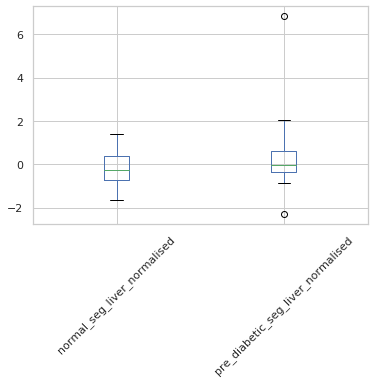

normal_seg_liver_normalised vs diabetic_seg_liver_normalised
ttest_score: -2.8524495521751283
p_value: 0.005131034557380649




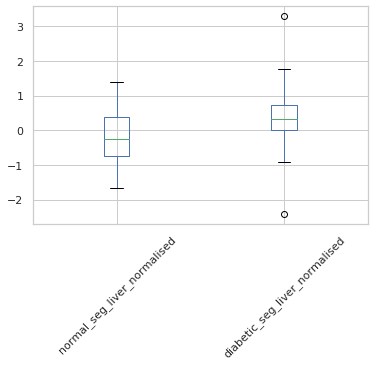

pre_diabetic_seg_liver_normalised vs diabetic_seg_liver_normalised
ttest_score: -0.08230652521899437
p_value: 0.9347251532047067




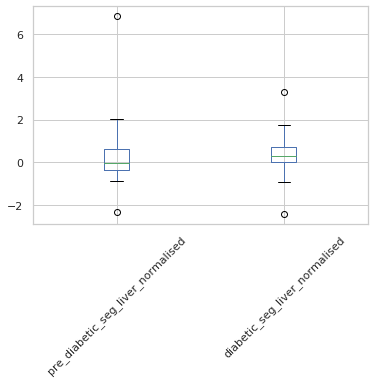

full_bayesian_0dot01
normal_seg_liver_normalised vs pre_diabetic_seg_liver_normalised
ttest_score: -3.013930577330124
p_value: 0.0030929147961951966




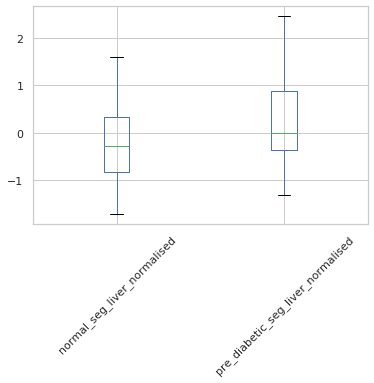

normal_seg_liver_normalised vs diabetic_seg_liver_normalised
ttest_score: -4.280055316985572
p_value: 3.8435234526309865e-05




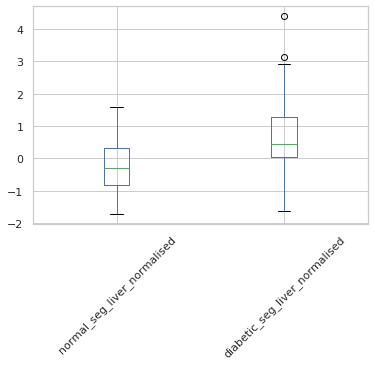

pre_diabetic_seg_liver_normalised vs diabetic_seg_liver_normalised
ttest_score: -1.4118669724590422
p_value: 0.1640616846851526




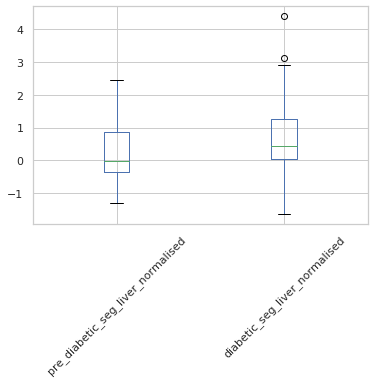

MC_dropout_quicknat
normal_seg_liver_normalised vs pre_diabetic_seg_liver_normalised
ttest_score: -3.6061167618254397
p_value: 0.0004395267931655543




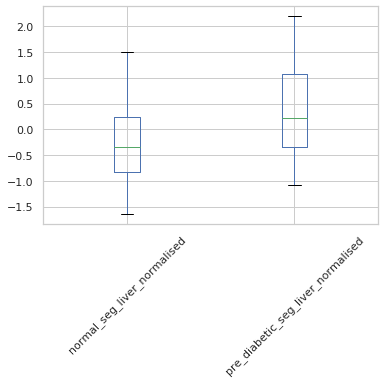

normal_seg_liver_normalised vs diabetic_seg_liver_normalised
ttest_score: -5.015667567988224
p_value: 1.9025214327554757e-06




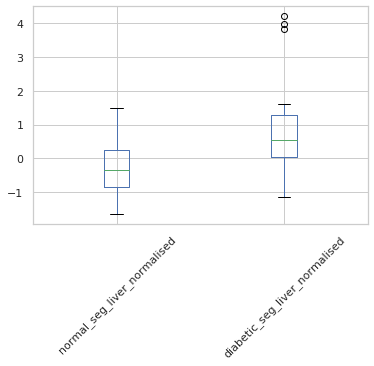

pre_diabetic_seg_liver_normalised vs diabetic_seg_liver_normalised
ttest_score: -1.7455681642931267
p_value: 0.08690840071618706




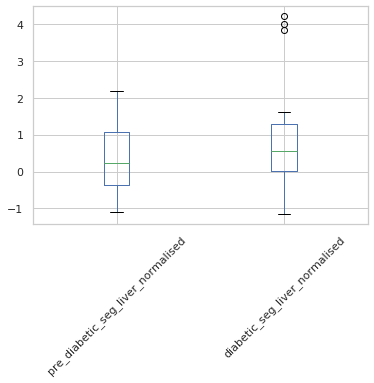

probabilistic_quicknat
normal_seg_liver_normalised vs pre_diabetic_seg_liver_normalised
ttest_score: -1.1642967137776528
p_value: 0.24640380442769677




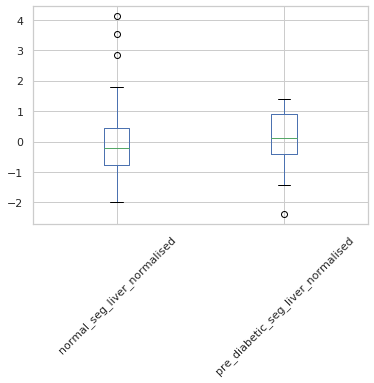

normal_seg_liver_normalised vs diabetic_seg_liver_normalised
ttest_score: -1.584775554488749
p_value: 0.11571657951182962




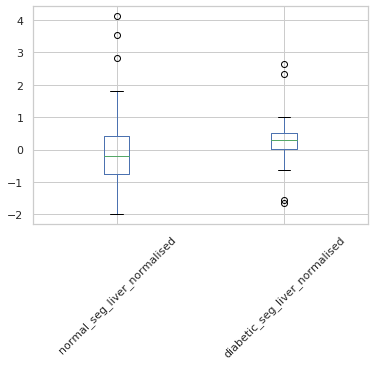

pre_diabetic_seg_liver_normalised vs diabetic_seg_liver_normalised
ttest_score: -0.6861715505041569
p_value: 0.4957127549808408




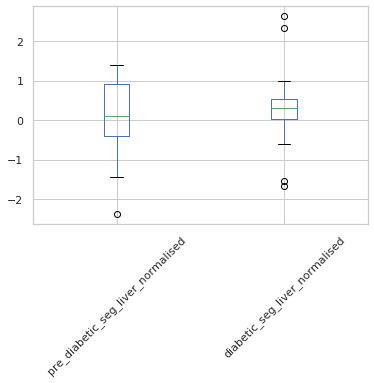

hierarchical_quicknat
normal_seg_liver_normalised vs pre_diabetic_seg_liver_normalised
ttest_score: -3.4823227228465785
p_value: 0.0006746073067002379




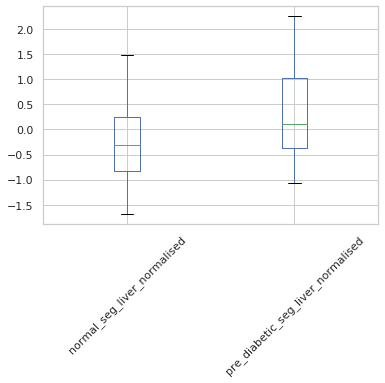

normal_seg_liver_normalised vs diabetic_seg_liver_normalised
ttest_score: -4.882538380676392
p_value: 3.3481260930611785e-06




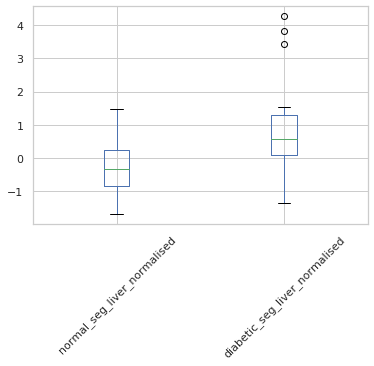

pre_diabetic_seg_liver_normalised vs diabetic_seg_liver_normalised
ttest_score: -1.6872168841875244
p_value: 0.09766960436388974




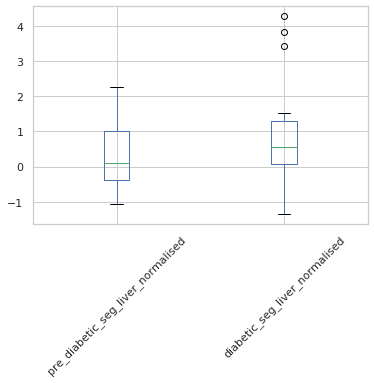

all_KORA_processed_False
normal_seg_liver_normalised vs pre_diabetic_seg_liver_normalised
ttest_score: -4.670051108923988
p_value: 4.7910162107203885e-06




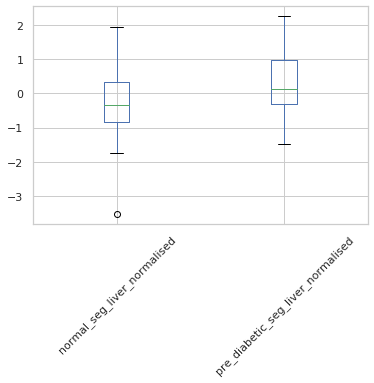

normal_seg_liver_normalised vs diabetic_seg_liver_normalised
ttest_score: -6.398374269456109
p_value: 8.364670714533498e-10




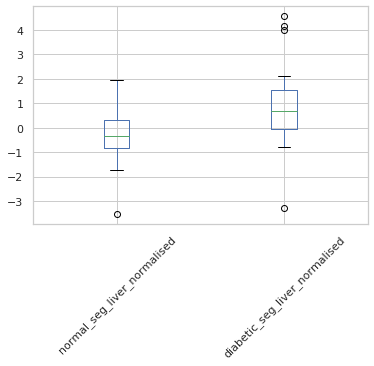

pre_diabetic_seg_liver_normalised vs diabetic_seg_liver_normalised
ttest_score: -2.277754891034489
p_value: 0.024728707164645824




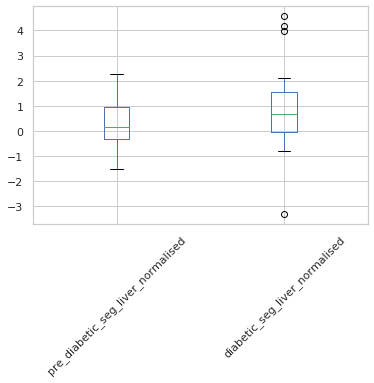

all_KORA_processed_True
normal_seg_liver_normalised vs pre_diabetic_seg_liver_normalised
ttest_score: -4.738713473030896
p_value: 3.506062914158784e-06




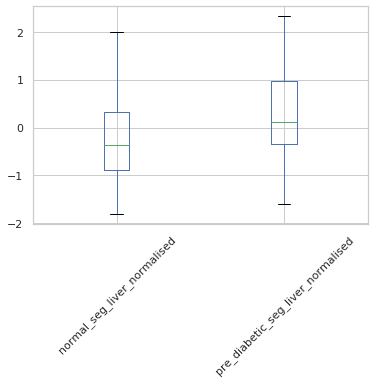

normal_seg_liver_normalised vs diabetic_seg_liver_normalised
ttest_score: -7.172708062833062
p_value: 9.33633408318639e-12




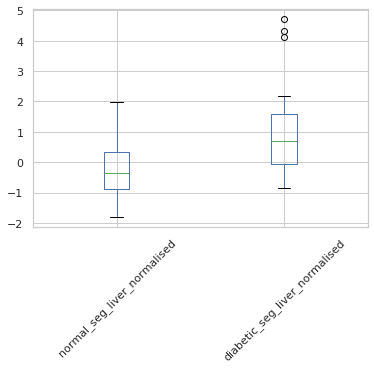

pre_diabetic_seg_liver_normalised vs diabetic_seg_liver_normalised
ttest_score: -2.7193983026680186
p_value: 0.007632988156583474




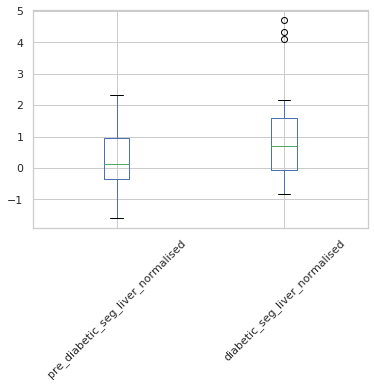

test_KORA_processed_False
normal_seg_liver_normalised vs pre_diabetic_seg_liver_normalised
ttest_score: -2.8387905445082597
p_value: 0.005250910599427199




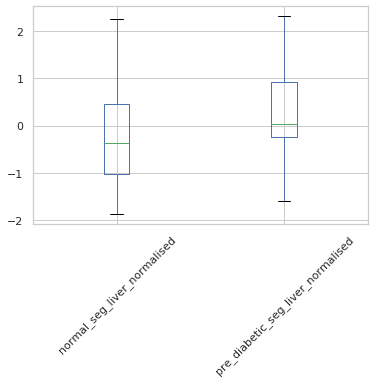

normal_seg_liver_normalised vs diabetic_seg_liver_normalised
ttest_score: -4.668832188548688
p_value: 8.139065950058526e-06




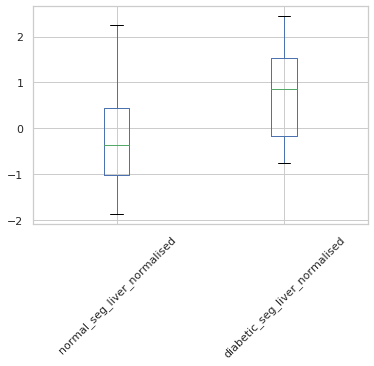

pre_diabetic_seg_liver_normalised vs diabetic_seg_liver_normalised
ttest_score: -2.003228898795602
p_value: 0.05018227729203536




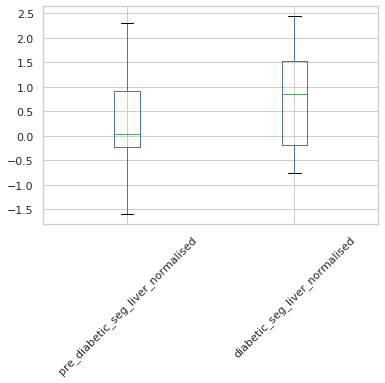

test_KORA_processed_True
normal_seg_liver_normalised vs pre_diabetic_seg_liver_normalised
ttest_score: -2.8187518582087194
p_value: 0.005563871785344981




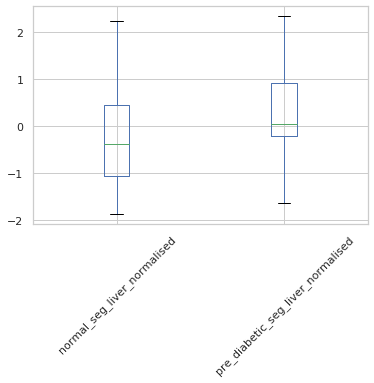

normal_seg_liver_normalised vs diabetic_seg_liver_normalised
ttest_score: -4.614391548667489
p_value: 1.0093433689114223e-05




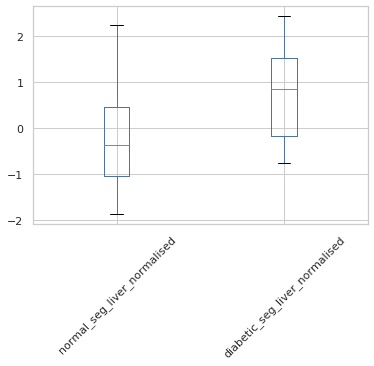

pre_diabetic_seg_liver_normalised vs diabetic_seg_liver_normalised
ttest_score: -1.9624038095917742
p_value: 0.05487687543527658




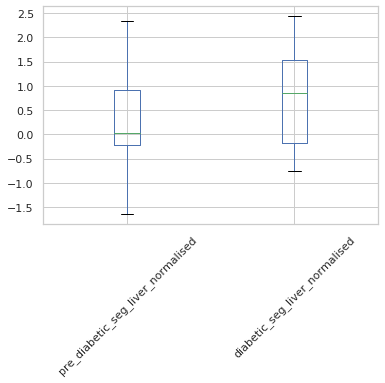

In [25]:
dicts = {}
for key, value in model_merged_feats_path_combined.items():
    print(key)
    df = pd.read_csv(value)
    df = rename(df)
    df = transform_to_categorical(df, ['diabetes_status', 'sex'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
    df = df.fillna(0)
    
    dfs = split_diabetes_state(df)
#     plot_and_ttest(dfs, ['normal_seg_spleen_normalised', 'pre_diabetic_seg_spleen_normalised', 'diabetic_seg_spleen_normalised'])
    individual_dicts = plot_and_ttest(dfs, ['normal_seg_liver_normalised', 'pre_diabetic_seg_liver_normalised', 'diabetic_seg_liver_normalised'])
    dicts[key] = individual_dicts
    
p_value_df = pd.DataFrame.from_dict(dicts).T   
p_value_df_styler = highlight_significance(p_value_df, 0.0001)   


In [26]:
p_value_df_styler

,normal_seg_liver_normalised vs pre_diabetic_seg_liver_normalised,normal_seg_liver_normalised vs diabetic_seg_liver_normalised,pre_diabetic_seg_liver_normalised vs diabetic_seg_liver_normalised
full_bayesian,0.00600449,0.00513103,0.934725
full_bayesian_0dot01,0.00309291,3.84352e-05,0.164062
MC_dropout_quicknat,0.000439527,1.90252e-06,0.0869084
probabilistic_quicknat,0.246404,0.115717,0.495713
hierarchical_quicknat,0.000674607,3.34813e-06,0.0976696
all_KORA_processed_False,4.79102e-06,8.36467e-10,0.0247287
all_KORA_processed_True,3.50606e-06,9.33633e-12,0.00763299
test_KORA_processed_False,0.00525091,8.13907e-06,0.0501823
test_KORA_processed_True,0.00556387,1.00934e-05,0.0548769


# Dice vs IOU plots

full_bayesian
dice vs sd: 0.848378774475892


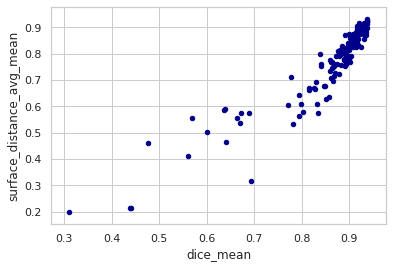

dice vs iou: 0.5914828733704434


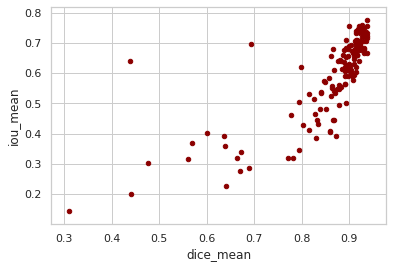

full_bayesian_0dot01
dice vs sd: 0.8209526098952631


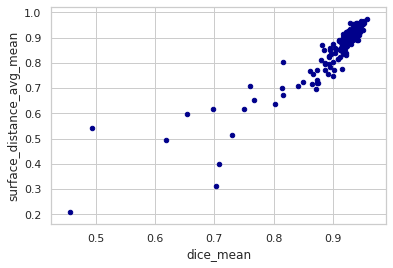

dice vs iou: 0.46401972295806504


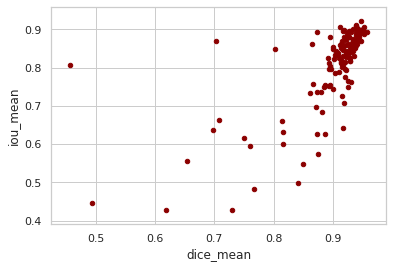

MC_dropout_quicknat
dice vs sd: 0.825344044346477


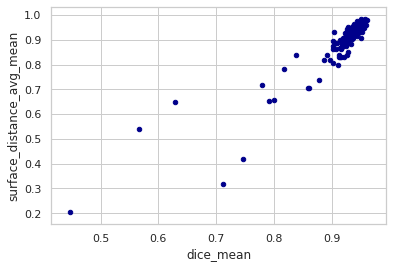

dice vs iou: 0.39538568171222543


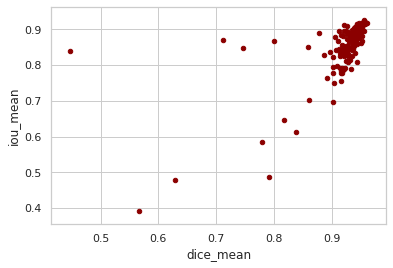

probabilistic_quicknat
dice vs sd: 0.8198119750548394


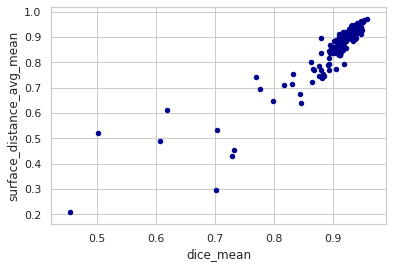

dice vs iou: 0.5092933723742227


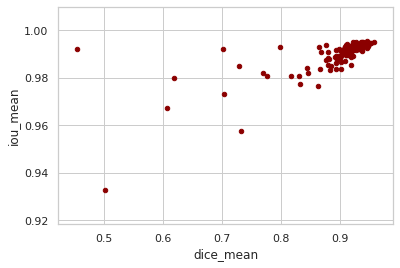

hierarchical_quicknat
dice vs sd: 0.8178009490409649


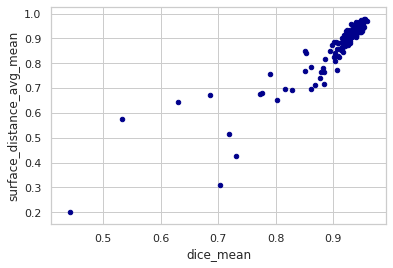

dice vs iou: 0.3453262196459317


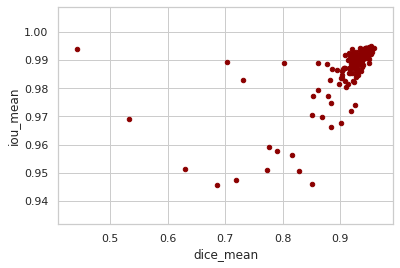

dataset cannot be processed!
dataset cannot be processed!
dataset cannot be processed!
dataset cannot be processed!


In [27]:

for key, value in model_merged_feats_path_combined.items():
    if 'KORA' in key:
        print('dataset cannot be processed!')
        continue
    print(key)
    df = pd.read_csv(value)
    df = rename(df)
    df = transform_to_categorical(df, ['diabetes_status', 'sex'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
    df = df.fillna(0)
    
 
    df.plot.scatter(x='dice_mean', y='surface_distance_avg_mean',c='DarkBlue')
    X, y = df['dice_mean'].values.reshape(-1,1),df['surface_distance_avg_mean'].values.reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    print('dice vs sd:', reg.score(X, y))
    plt.show()
    df.plot.scatter(x='dice_mean', y='iou_mean',c='DarkRed')
    X, y = df['dice_mean'].values.reshape(-1,1),df['iou_mean'].values.reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    print('dice vs iou:', reg.score(X, y))
    plt.show()